In [1]:
"""
Introduction to image analysis using scikit-image: https://scikit-image.org/

Instructor: Shaina Lu (slu@cshl.edu)
2019 URP Data Analysis using Python Course
9 July 2019"""

'\nIntroduction to image analysis using scikit-image: https://scikit-image.org/\n\nInstructor: Shaina Lu (slu@cshl.edu)\n2019 URP Data Analysis using Python Course\n9 July 2019'

# Imports and Globals

In [2]:
#imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from skimage import io, data

# Quick review of numpy for images

For more on manipulating images in scikit-image, check out: https://scikit-image.org/docs/dev/user_guide/numpy_images.html
(This following example is lightly modified form this resource too!)

### Load sample data and poke around to understand it

In [3]:
#get sample data from skimage library
camera = data.camera()
type(camera)

numpy.ndarray

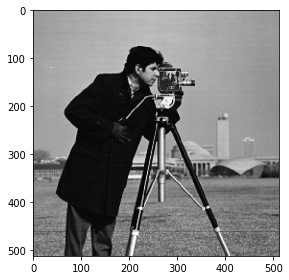

In [4]:
#let's see what the image looks like
io.imshow(camera)
#plt.show()

In [5]:
#this image is represented as a numpy array
print(camera)

[[156 157 160 ... 152 152 152]
 [156 157 159 ... 152 152 152]
 [158 157 156 ... 152 152 152]
 ...
 [121 123 126 ... 121 113 111]
 [121 123 126 ... 121 113 111]
 [121 123 126 ... 121 113 111]]


In [6]:
#check shape and size of sample data
print(camera.shape)
print(camera.size)

(512, 512)
262144


Note, size is the total number of entries in the numpy array representing the image. In other words, it's the total number of pixels.

In [7]:
#get a basic idea of pixel intenstities
print(camera.min())
print(camera.max())
print(camera.mean())

0
255
118.31400299072266


### Indexing the array to manipulate the image

In [8]:
#indexing a numpy array: (row, column) and origin (0,0) is top-left
#get the value of the pixel in the 20th row, and 15th column
camera[20,15]

157

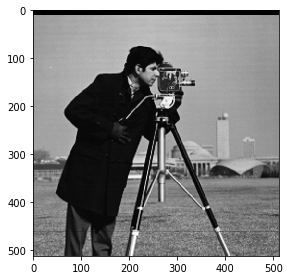

In [9]:
#make the first 10 rows black using slicing
camera[:10] = 0
io.imshow(camera)

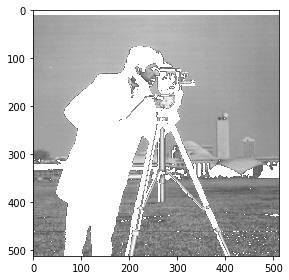

In [10]:
#masking- make all pixels less than 87 white
mask = camera < 87
camera[mask] = 255
io.imshow(camera)

# Bacterial Cell Segmentation

The following exercise was adapted from a course taught by Rob Phillisp (CalTech) called "Physical Biology of the Cell". We will use microscopy images of a growing E. coli colony over 35 time points. For more information and additonal resources: www.rpgroup.caltech.edu/courses/index.html

### Examining an example image

Before we begin, please download the data for this section from the GitHub repository under: shainalu/urpcourse19/data/lecture6/colonygrowth

In [11]:
#file path
#note: the file path will vary for each person depending on where you've stored the images
infile = "/home/slu/urpcourse19/data/lecture6/colonygrowth/EcoliGrowth05.tif"

In [12]:
#read in the image using sk-image
img5 = io.imread(infile)

In [13]:
#remember the image will be represented as an array of pixel intensities
img5

array([[129, 131, 130, ..., 135, 136, 139],
       [135, 135, 134, ..., 136, 136, 134],
       [139, 135, 136, ..., 132, 133, 137],
       ...,
       [131, 131, 136, ..., 130, 128, 129],
       [133, 136, 138, ..., 125, 128, 127],
       [138, 136, 139, ..., 131, 128, 131]], dtype=uint8)

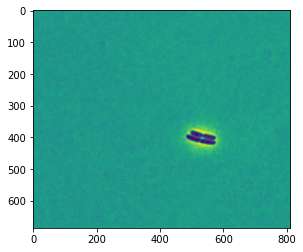

In [14]:
#let's take a look at the image
plt.imshow(img5)

Note that this is not necessarily the orginial coloring of the image. It is a mapping of the pixel intensities to a default matplotlib color map. So, we can manipulate that color map to give us gray-scale image.

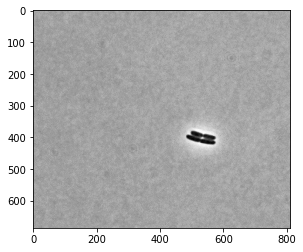

In [15]:
#now let's look at it in gray-scale to simplify the visualization for segementation
plt.imshow(img5, cmap=plt.cm.Greys_r)

As humans, we can easily see where the bacteria (dark pixels) are compared to the background (light pixels). The computer only sees the numerical intensties of the pixels, which can vary from image to image depending on the light intensity during microscopy imaging. To simplify segementation across multiple images, let's start by normalizing the pixels in a range from 0 to 1 where the darkest pixel would become 0 and the lightest would be 1.

In [16]:
#normalize pixel values from 0 to 1
img5_norm = ((img5 - np.min(img5)) / (np.max(img5)-np.min(img5)))

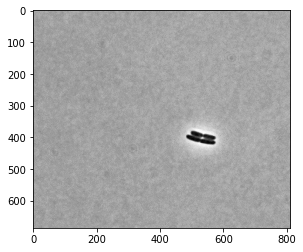

In [17]:
#look at the normalized image
plt.imshow(img5_norm, cmap=plt.cm.Greys_r)

Visually, there doesn't seem to be much of a difference between the two images, but let's take a look at the underlying matrix of numbers.

In [18]:
img5_norm

array([[0.52564103, 0.53418803, 0.52991453, ..., 0.55128205, 0.55555556,
        0.56837607],
       [0.55128205, 0.55128205, 0.54700855, ..., 0.55555556, 0.55555556,
        0.54700855],
       [0.56837607, 0.55128205, 0.55555556, ..., 0.53846154, 0.54273504,
        0.55982906],
       ...,
       [0.53418803, 0.53418803, 0.55555556, ..., 0.52991453, 0.52136752,
        0.52564103],
       [0.54273504, 0.55555556, 0.56410256, ..., 0.50854701, 0.52136752,
        0.51709402],
       [0.56410256, 0.55555556, 0.56837607, ..., 0.53418803, 0.52136752,
        0.53418803]])

Looking at the pixel values, we can now see that the numbers do indeed range from 0 to 1. The images don't change visually, becuase matplotlib maps the range to the color map range.

Now that we've normalized the image, let's take a look at the distribution of pixel values to get an idea of what pixel values the background and bacteria have.

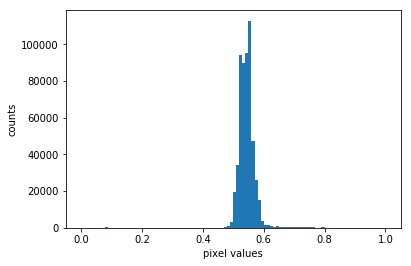

In [19]:
#histogram of pixel intensities 
plt.hist(img5_norm.flat, bins=100)
plt.xlabel("pixel values")
plt.ylabel("counts")
plt.show()

Let's zoom in on the y-axis to get a closer look at the pixels with low counts.

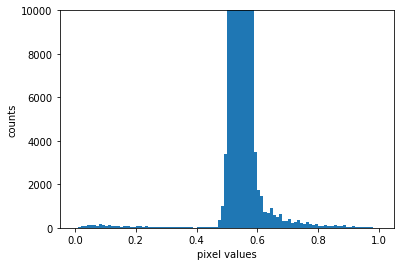

In [22]:
#zoomed y-axis histogram of pixel intensities 
plt.hist(img5_norm.flat, bins=100)
plt.xlabel("pixel values")
plt.ylabel("counts")
plt.ylim([0,10000])
plt.show()

Looking at the zoomed histogram, we see a subtle bimodal distribution. Let's assume that the lower distribution represents the bacteria (darker pixels are closer to 0) and that the peak at values higher than 0.4 represents the background. So, for this image we will try a threshold of 0.4 to segment the image (i.e. separate the bacteria from the background). Using the thresholding approach, we'll binarize the image by assigning all pixel values below our threhold to 1 and all those above to 0.

In [23]:
#threshold the normalized image
threshold = 0.4
seg5 = img5_norm < threshold

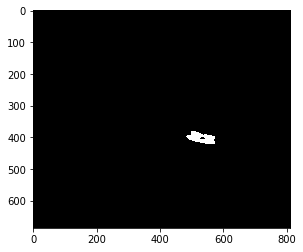

In [24]:
#let's take a look at the segementation to see how we did
plt.imshow(seg5, cmap=plt.cm.Greys_r)

The threshold value of 0.4 looks pretty good here, but feel free to play around with different threholding values to see if you can improve the image segmentation. Another realtively simple way to pick the threshold values is the examine the pixel values by hand of the bacteria and the background.

### Does this threshold work for another image in the series?

Now that we've sucessfully segmented one image in the bacterial series, let's see if the threshold we chose holds up for an second image later in the growth of the colony.

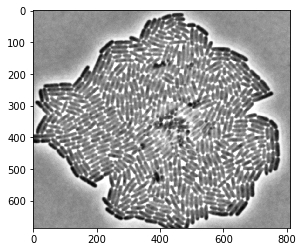

In [25]:
#read in file and show image
infile = "/home/slu/urpcourse19/data/lecture6/colonygrowth/EcoliGrowth35.tif"
img35 = io.imread(infile)
plt.imshow(img35, cmap=plt.cm.Greys_r)

In [26]:
#normalize
img35_norm = ((img35 - np.min(img35)) / (np.max(img35)-np.min(img35)))

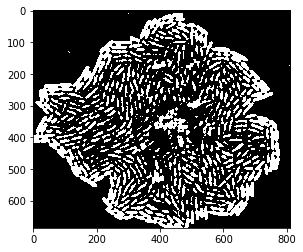

In [27]:
#segmentation
threshold = 0.4
seg35 = img35_norm < threshold
plt.imshow(seg35, cmap=plt.cm.Greys_r)

It seems to hold up well enough between the earlier and later images of bacterial colony growth. Feel free to play around with threshold values to find ones that may work better. 

You may have noticed that we lost some of the lighter cells in the middle of the colony. Binary thresholding for image segementation is one of the simplest techniques for segmentation and in practice only really works for homogenous cells with nice rounded edges. Image segmentation techniques constitutes a whole active area of research. Segementation is especially hard in neuroscience, since neurons have notoriously non-uniform shapes. More sophisticated techniques rely on statistical methods such as watershed segemenation and probabilistic segmentation-- examples of which we discussed in the lecture.

### Look at all the images in the series and calculate total area of bacteria based on image segmentation

Now we will do segementation for all the images in the growth series and plot a growth curve by calculating the total area of bacteria based on the segementation.

In [29]:
#set up for loop to find total area of bacteria for all images
threshold = 0.4
numimages=35
bacterialarea = []
for i in range(numimages):
    #read in data/images
    #get each image name per iteration of loop using string formatting
    infile = "/home/slu/urpcourse19/data/lecture6/colonygrowth/EcoliGrowth%s.tif" %str(i+1)
    currimg = io.imread(infile)
    
    #normalize image
    currnorm = ((currimg - np.min(currimg)) / (np.max(currimg)-np.min(currimg)))
    
    #segmentation
    currseg = currnorm < threshold
    
    #calculate the total area of bacteria (number of pixels == 1) and save to the list
    currarea = np.sum(currseg)
    bacterialarea.append(currarea)

Plot a growth curve of the colony

In [33]:
#make an array representing the timepoints of the images
deltatime = 5 #5 minutes between each image
totaltime = deltatime * numimages
timepoints = range(0,totaltime,deltatime)

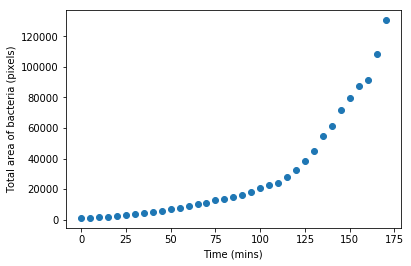

In [42]:
plt.scatter(timepoints, bacterialarea)
plt.xlabel("Time (mins)")
plt.ylabel("Total area of bacteria (pixels)")
plt.show()

For those of you familiar with bacterial growth, this indeed looks like the exponential growth phase of bacteria including perhaps a bit of the lag phase at the begining. For those interested, feel free to extend this analysis by rescaling the area. Specifically normalizing so that the bacterial area at time 0 is 1 (i.e. divide the bacterial area of each image by the area of bacteria in the first image). You can further extend this, by fitting an exponential curve. Once you've given it a try, feel free to check out the solution here: www.rpgroup.caltech.edu/be262/code/bacterial_growth.html (note, many of the variable names and some of the code will be different from ours)